Ising model using Monte Carlo methods
=====================================



## Theoretical description



The [Ising model](https://en.wikipedia.org/wiki/Ising_model) is a statistical mechanics model originally developed to study [ferromagnetism](https://en.wikipedia.org/wiki/Ferromagnetism). A system
of magnetic particles can be described by a two dimensional arrangement (lattice) of atoms. To each atom
$i$ on the lattice, a discrete spin magnetic moment $\sigma_i=\pm 1$ is assigned.

<img src="../figures/ising_grid_small.png" alt="Schematic representation of the 2D spin arrangement" width="200"/>

The Hamiltonian of the system is given by:

<div class="LaTeX" id="orgd1901d9">
\begin{equation}
H = -J\sum_{\langle ij \rangle} \sigma_i\sigma_j
\end{equation}

</div>

where the symbol $\langle ij \rangle$ implies a sum over the nearest neighbors and $J$ is the strength
of the exchange interaction. We will consider in this example ferromagnetic systems only, which implies
a value of $J > 0$. In the following exercise we set it to 1. 

The canonical [partition function](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics)) of the system is given by:

<div class="LaTeX" id="org82178ff">
\begin{equation}
Z(\beta) = \sum_S e^{-\beta H}
\end{equation}

</div>

where $\beta = 1/k_B T$ with $T$ being the temperature and $k_B$ the Boltzmann’s constant. The sum runs
over all possible spin configurations $S$ of the system. Following the statistical mechanics reasoning, observables
are computed as follows:

<div class="LaTeX" id="org42b9c84">
\begin{equation}
{\langle O \rangle} = \frac{1}{Z(\beta)}\sum_S O(S) e^{-\beta H}
\end{equation}

</div>

The total number of states for a square grid of length $L$ (**How many are there?**) suffers
from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). In addition,
the exact solutions of the 2D Ising model are rather difficult to derive, see this [blog post](https://gandhiviswanathan.wordpress.com/2015/01/09/onsagers-solution-of-the-2-d-ising-model-the-combinatorial-method/) for a very nice sketch of the derivation. For these reasons, Monte Carlo methods are a great tool
to study this system.

Using the following Metropolis algorithm, instead, the estimation of the observable's value is then given by:

<div class="LaTeX" id="org98c35d0">
\begin{equation}
\langle O \rangle \approx \frac{1}{N} \sum_i^{N} O_i
\end{equation}

</div>



### Metropolis algorithm



We will assume ergodicity in our implementation, together with the `single spin-flip dynamics` principle.
This means that in each transition we will change only one spin site on the lattice. We can then set our
transition probability to:

<div class="LaTeX" id="orgecc279e">
\begin{equation}
P(x, y) = g(x, y)A(x, y)
\end{equation}

</div>

where the selection probability is homogeneous $g(x, y) = 1/L^2$. The acceptance probability can be
set to the Metropolis choice after applying [detail balance](https://en.wikipedia.org/wiki/Detailed_balance):

<div class="LaTeX" id="orgffab8ae">
\begin{equation}
A(x, y) = 
  \begin{cases}
   e^{-\beta ( \delta E)} & \delta E > 0 \\
   1 & \text{otherwise}
  \end{cases}
\end{equation}

</div>
$\delta$ E is the energy difference between two sampling configurations.

The algorithm's steps are then:

1.  Pick a spin site with probability $g(x, y)$ and flip it
2.  Compute the energy change $\delta E$
3.  Accept the new configuration with probability $A(x, y)$
4.  Repeat



## Coding exercise



### Setting the environment



In [2]:
"""Imports and global variables"""
!pip install numpy
!pip install matplotlib
!pip install numba
!pip install tqdm

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/b9/14/78635daab4b07c0930c919d451b8bf8c164774e6a3413aed04a6d95758ce/numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 3.5 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/5a/20/f56d5b88450593ccde3f283e338f3f976b2e479bddd9a147f14f66ee1ca7/matplotlib-3.9.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/05/11/57335544a3027e9b96a05948c32e566328e3a2f84b7b99a325b7a06d2b06/contourpy-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm.notebook import tqdm
import time

### Main functions



In [23]:
def init_state(L):
    """Initialized spin grid"""
    grid = np.random.choice([-1,1],size=(L,L))
    return grid

@jit(nopython=True, cache=True)
def cal_energy(grid, L):
    """Compute energy of new configuration"""
    en = 0
    for i in np.arange(L):
        for j in np.arange(L):
            s = grid[i, j]
            neighbor_s = grid[(i + 1) % L, j] + \
                         grid[(i - 1) % L, j] + \
                         grid[i, (j + 1) % L] + \
                         grid[i, (j - 1) % L]
            en -= s * neighbor_s # we take J = 1.0
    return en / 2  # this 2 coming from the double counting of the i,j pairs

@jit(nopython=True, cache=True)
def mc_update(grid, beta, L):
    """Updating step using the MH algorithm"""
    for _ in np.arange(L * L):
        # Select a center with probability 1/L^2
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        
        # Get the spin value from selected center
        s = grid[i,j]
        
        # Periodic boundary conditions (4 neighbors)
        neighbor_s = grid[(i + 1) % L, j] + \
                     grid[(i - 1) % L, j] + \
                     grid[i, (j + 1) % L] + \
                     grid[i, (j - 1) % L]
        
        # Change in energy
        dE = 2 * s * neighbor_s  # this 2 coming from the flip of a given s, e.g. from -1/2 to 1/2, the energy change is the double of the s * neighbor_s

        # TODO: Apply acceptance criterion and update grid
    
    return grid


### Set numerical experiment conditions



These are the input parameters of the simulation, they can be tuned in order to speed up or refine the results.
For convenience reasons, the temperature will be given in units of $[k_B/J]\cdot K$.



In [24]:
# Parameter initialization
Ntemp = 50
temp = np.linspace(1.5, 3.25, Ntemp)
length = 10
Nsteps = 10000

# Variables initialization
energy = np.zeros(Ntemp)

### Run the simulation and compute expectation value



In [25]:
start = time.time()
for tdx, tval in enumerate(tqdm(temp)):
    # Compute beta factor
    beta = 1 / tval

    # Initial grid
    grid = init_state(length)

    # Run Monte Carlo steps
    ent = 0
    for _ in range(Nsteps):
        # TODO finish the looping code

    # Set energy value
    energy[tdx] = ent / (Nsteps * length**2)
end = time.time()
run_time = (end - start) / 60
print(f'It took {run_time:.2f} minutes to run the code.')

  0%|          | 0/50 [00:00<?, ?it/s]

It took 0.09 minutes to run the code.


### Find critical temperature



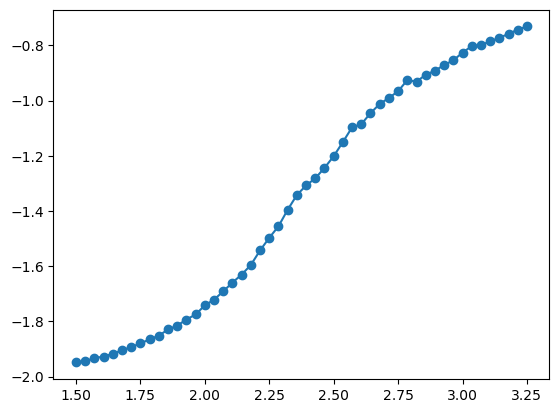

In [26]:
# PLot curve
plt.plot(temp, energy, 'o-')

# Inflection point
# TODO

# Show
plt.show()

### Questions:



1.  Complete all missing code sections, Chatgpt could be a good tool assisting coding.
2.  Plot the energy temperature curve.
3.  Which are the units of the energy and temperature on the plot?
4.  What is the value of the critical temperature? Compare with the [analytical](https://en.wikipedia.org/wiki/Square_lattice_Ising_model#Critical_temperature) value.

